In [1]:
from mxnet import gluon
from mxnet import image
from mxnet import nd
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior
from mxnet.contrib.ndarray import MultiBoxTarget

In [2]:
from mxnet import gluon
root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/''gluon/dataset/pikachu/')
data_dir = '/Users/Sinyer/Python/Data/pikachu/'
dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8','train.idx': 'dcf7318b2602c06428b9988470c731621716c393','val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
for k, v in dataset.items():
    gluon.utils.download(root_url+k, data_dir+k, sha1_hash=v)

In [3]:
data_shape = 256
batch_size = 32
rgb_mean = nd.array([123, 117, 104])

def get_iterators(data_shape, batch_size):
    class_names = ['pikachu']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(batch_size=batch_size,data_shape=(3, data_shape, data_shape),path_imgrec=data_dir+'train.rec',path_imgidx=data_dir+'train.idx',shuffle=True,mean=True,rand_crop=1,min_object_covered=0.95,max_attempts=200)
    val_iter = image.ImageDetIter(batch_size=batch_size,data_shape=(3, data_shape, data_shape),path_imgrec=data_dir+'val.rec',shuffle=False,mean=True)
    return train_iter, val_iter, class_names, num_class

train_data, test_data, class_names, num_class = get_iterators(data_shape, batch_size)

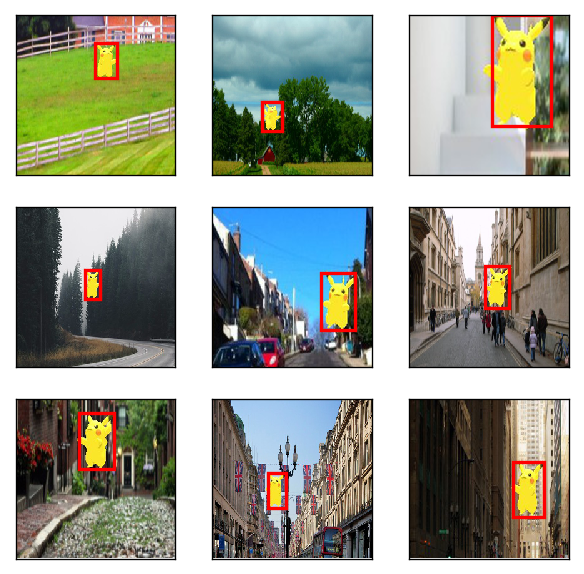

In [5]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def box_to_rect(box, color, linewidth=3):
    box = box.asnumpy()
    return plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, edgecolor=color, linewidth=linewidth)

batch = train_data.next()
_, figs = plt.subplots(3, 3, figsize=(6,6))
for i in range(3):
    for j in range(3):
        img, labels = batch.data[0][3*i+j], batch.label[0][3*i+j]
        img = img.transpose((1, 2, 0)) + rgb_mean
        img = img.clip(0,255).asnumpy()/255
        fig = figs[i][j]
        fig.imshow(img)
        for label in labels:
            rect = box_to_rect(label[1:5]*data_shape,'red',2)
            fig.add_patch(rect)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plt.show()

In [ ]:
def class_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

def down_sample(num_filters):
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

def flatten_prediction(pred):
    return pred.transpose(axes=(0,2,3,1)).flatten()

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

def body():
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

def toy_ssd_model(num_anchors, num_classes):
    downsamplers = nn.Sequential()
    for _ in range(3):
        downsamplers.add(down_sample(128))
    class_predictors = nn.Sequential()
    box_predictors = nn.Sequential()
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors, num_classes))
        box_predictors.add(box_predictor(num_anchors))
    model = nn.Sequential()
    model.add(body(), downsamplers, class_predictors, box_predictors)
    return model

def toy_ssd_forward(x, model, sizes, ratios, verbose=False):
    body, downsamplers, class_predictors, box_predictors = model
    anchors, class_preds, box_preds = [], [], []
    x = body(x)
    for i in range(5):
        anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        class_preds.append(flatten_prediction(class_predictors[i](x)))
        box_preds.append(flatten_prediction(box_predictors[i](x)))
        if i < 3:
            x = downsamplers[i](x)
        elif i == 3:
            x = nd.Pooling(x, global_pool=True, pool_type='max',kernel=(x.shape[2], x.shape[3]))
    return (concat_predictions(anchors),concat_predictions(class_preds),concat_predictions(box_preds))

class ToySSD(gluon.Block):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        self.sizes = [[.2,.272], [.37,.447], [.54,.619], [.71,.79], [.88,.961]]
        self.ratios = [[1,2,.5]]*5
        self.num_classes = num_classes
        self.verbose = verbose
        num_anchors = len(self.sizes[0]) + len(self.ratios[0]) - 1
        with self.name_scope():
            self.model = toy_ssd_model(num_anchors, num_classes)

    def forward(self, x):
        anchors, class_preds, box_preds = toy_ssd_forward(x, self.model, self.sizes, self.ratios,verbose=self.verbose)
        class_preds = class_preds.reshape(shape=(0, -1, self.num_classes+1))
        return anchors, class_preds, box_preds
    
def training_targets(anchors, class_preds, labels):
    class_preds = class_preds.transpose(axes=(0,2,1))
    return MultiBoxTarget(anchors, labels, class_preds)

class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pj = output.pick(label, axis=self._axis, keepdims=True)
        loss = - self._alpha * ((1 - pj) ** self._gamma) * pj.log()
        return loss.mean(axis=self._batch_axis, exclude=True)
    
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return loss.mean(self._batch_axis, exclude=True)

In [ ]:
ctx = mx.gpu(0)
train_data.reshape(label_shape=(3, 5))
train_data = test_data.sync_label_shape(train_data)
net = ToySSD(num_class)
net.initialize(init.Xavier(magnitude=2), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

In [ ]:
for epoch in range(30):
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    for i, batch in enumerate(train_data):
        x = batch.data[0].as_in_context(ctx)
        y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            anchors, class_preds, box_preds = net(x)
            box_target, box_mask, cls_target = training_targets(anchors, class_preds, y)
            loss1 = cls_loss(class_preds, cls_target)
            loss2 = box_loss(box_preds, box_target, box_mask)
            loss = loss1 + loss2
        loss.backward()
        trainer.step(batch_size)
        cls_metric.update([cls_target], [class_preds.transpose((0,2,1))])
        box_metric.update([box_target], [box_preds * box_mask])
    print('Epoch %2d, train %s %.2f, %s %.5f, time %.1f sec' % (epoch, *cls_metric.get(), *box_metric.get(), time.time()-tic))